In [1]:
import pandas as pd
import numpy as np
import os
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import time

import matplotlib.pyplot as plt

# Data Analysis:

In [3]:
train_df = pd.read_csv('train.csv', nrows = 6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
train_df = train_df.dropna(axis=1)

In [4]:
train_df.head()

acoustic_data  time_to_failure
0             12           1.4691
1              6           1.4691
2              8           1.4691
3              5           1.4691
4              8           1.4691

In [5]:
train_df.tail()

acoustic_data  time_to_failure
5999995              6        11.452497
5999996              5        11.452497
5999997              4        11.452497
5999998              3        11.452497
5999999              3        11.452497

Pembagian traind data

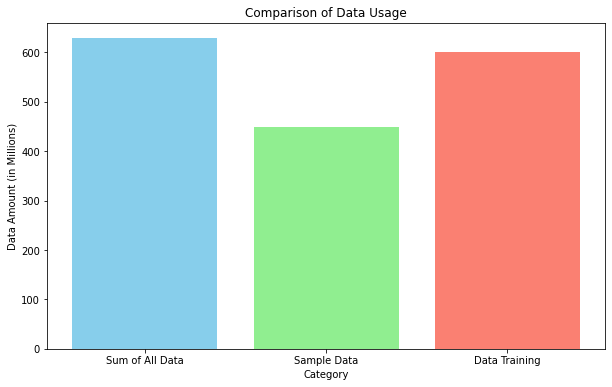

In [7]:
import matplotlib.pyplot as plt

# Data
labels = ['Sum of All Data', 'Sample Data', 'Data Training']
values = [629, 450, 600]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['skyblue', 'lightgreen', 'salmon'])
plt.xlabel('Category')
plt.ylabel('Data Amount (in Millions)')
plt.title('Comparison of Data Usage')
plt.show()

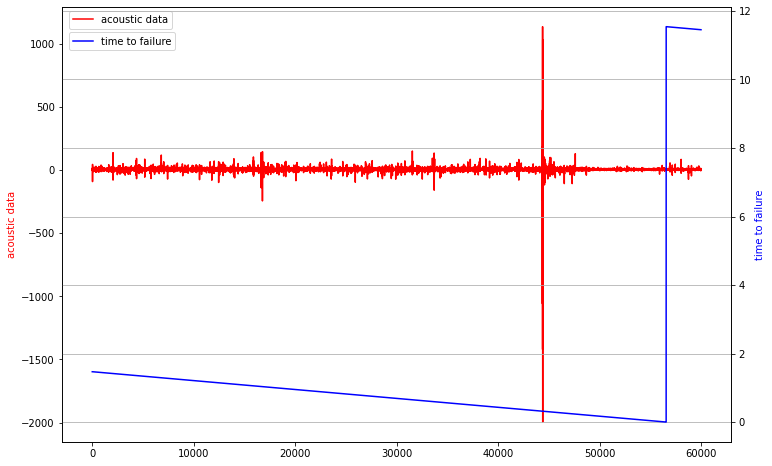

In [8]:
train_ad_sample = train_df['acoustic_data'].values[::100] # :: means skip by 100
train_ttf_sample = train_df['time_to_failure'].values[::100]

# twinx() - share same X-axis but with diff scales

fig, ax1 = plt.subplots(figsize=(12, 8))

plt.plot(train_ad_sample, color='r')
ax1.set_ylabel('acoustic data', color='r')
plt.legend(['acoustic data'], loc=(0.01, 0.95))

ax2 = ax1.twinx()

plt.plot(train_ttf_sample, color='b')
ax2.set_ylabel('time to failure', color='b')
plt.legend(['time to failure'], loc=(0.01, 0.9))

plt.grid(True)


# Feature Engineering:

In [9]:
def gen_features(X):
    strain = []
    #strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    #strain.append(X.kurtosis())
    #strain.append(X.skew())
    #strain.append(np.quantile(X,0.01))
    #strain.append(np.quantile(X,0.05))
    #strain.append(np.quantile(X,0.95))
    #strain.append(np.quantile(X,0.99))
    #strain.append(np.abs(X).min())
    strain.append(np.abs(X).max())
    #strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

# Prepare Training Data:

In [12]:
import pandas as pd
import numpy as np

def gen_features(series):
    features = {
        'std': series.std(),
        'min': series.min(),
        'max': series.max(),
        'abs_max': np.abs(series).max(),
        'abs_std': np.abs(series).std()
    }
    return pd.Series(features)

# Load the data
train = pd.read_csv('train.csv', iterator=True, chunksize=150000,
                    dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()

# Process each chunk
for df in train:
    print(df.shape)
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

# Now X_train will have the features: ['std', 'min', 'max', 'abs_max', 'abs_std']
# and y_train will have the corresponding time_to_failure values.

/tmp/ipykernel_9459/3935158247.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_train = pd.Series()
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))


(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(150000, 2)
(150000, 2)
(150000, 2)
(150000, 2)


/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append 

(45480, 2)


/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/3935158247.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(ch, ignore_index=True)
/tmp/ipykernel_9459/3935158247.py:26: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))


In [13]:
print("Panjang X_train:", len(X_train))
print("Panjang y_train:", len(y_train))

Panjang X_train: 4195
Panjang y_train: 4195


In [14]:
X_train.describe()

std          min          max      abs_max      abs_std
count  4195.000000  4195.000000  4195.000000  4195.000000  4195.000000
mean      6.547788  -149.190942   163.522288   170.046246     5.750165
std       8.503939   265.087984   272.930331   296.887015     8.339211
min       2.802720 -5515.000000    23.000000    23.000000     2.589085
25%       4.478637  -154.000000    92.000000    94.000000     3.862810
50%       5.618798  -111.000000   123.000000   127.000000     4.781513
75%       6.880904   -79.000000   170.000000   175.000000     5.887947
max     153.703569   -15.000000  5444.000000  5515.000000   150.432368

In [15]:
y_train.describe()

count    4195.000000
mean        5.683670
std         3.673246
min         0.006398
25%         2.635348
50%         5.358796
75%         8.177500
max        16.103196
dtype: float64

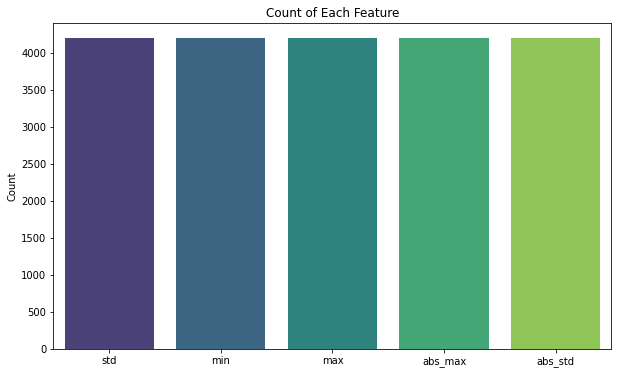

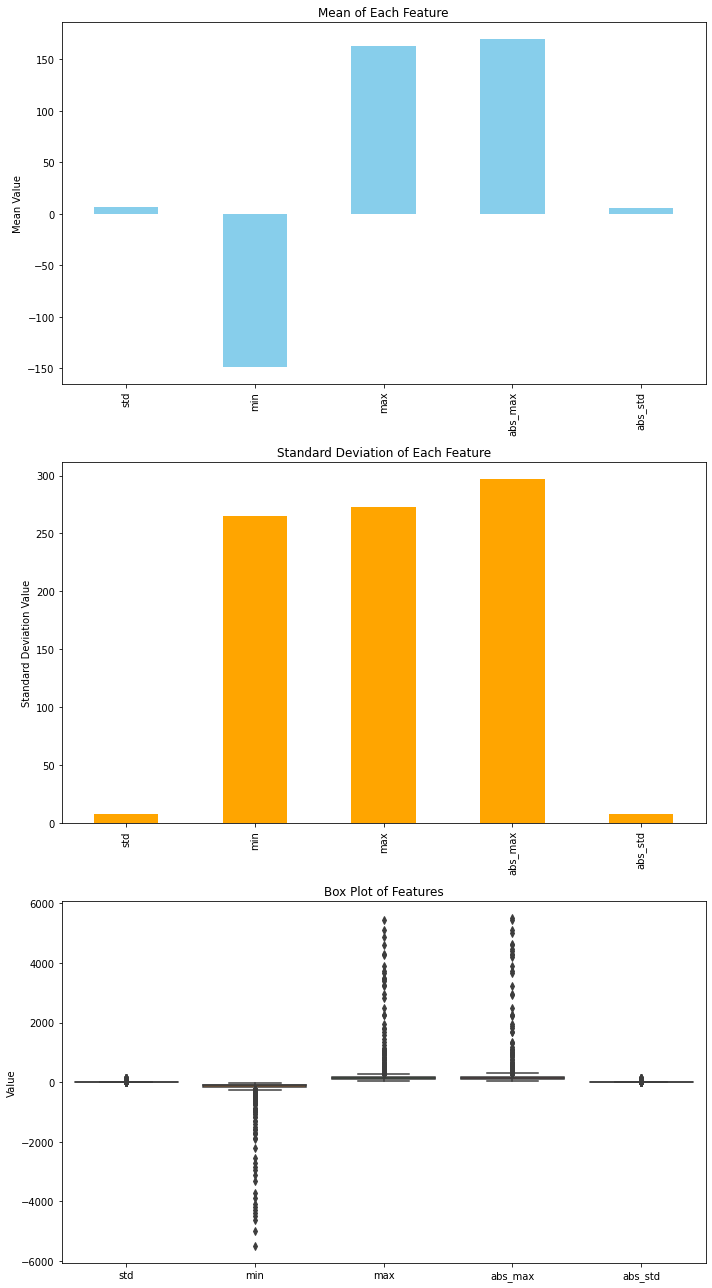

In [16]:
import seaborn as sns

# Menghitung jumlah data (count) per fitur
count = X_train.describe().loc['count']

# Menghitung mean dan std untuk setiap fitur
mean_std = X_train.describe().loc[['mean', 'std']]

plt.figure(figsize=(10, 6))
sns.barplot(x=count.index, y=count.values, palette='viridis')
plt.title('Count of Each Feature')
plt.ylabel('Count')
plt.show()

fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Plot mean
mean_std.loc['mean'].plot(kind='bar', color='skyblue', ax=axs[0])
axs[0].set_title('Mean of Each Feature')
axs[0].set_ylabel('Mean Value')

# Plot std
mean_std.loc['std'].plot(kind='bar', color='orange', ax=axs[1])
axs[1].set_title('Standard Deviation of Each Feature')
axs[1].set_ylabel('Standard Deviation Value')

# Box Plot
sns.boxplot(data=X_train, ax=axs[2])
axs[2].set_title('Box Plot of Features')
axs[2].set_ylabel('Value')

plt.tight_layout()
plt.show()

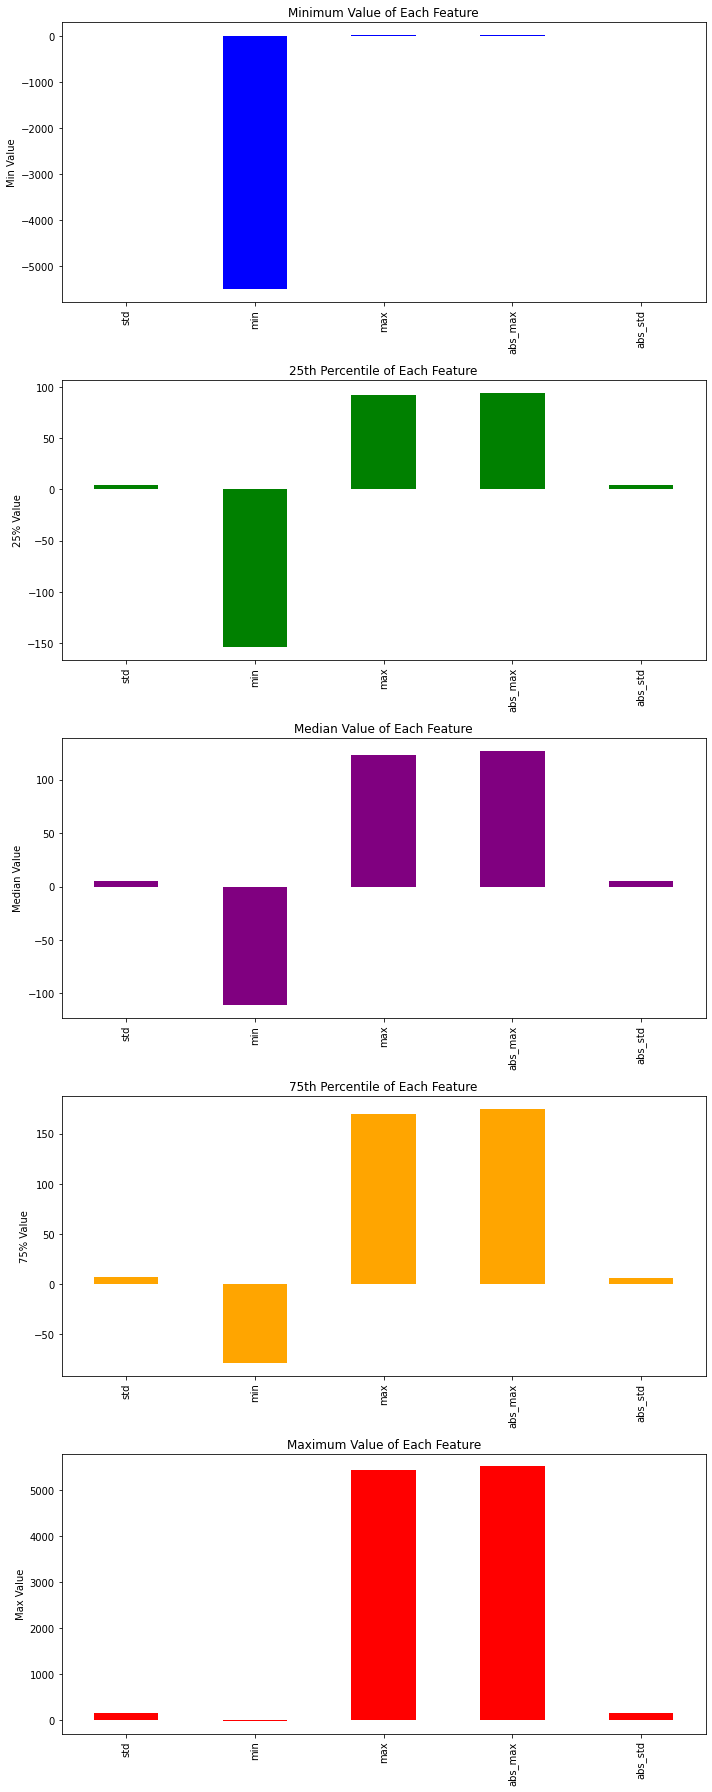

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Menghitung statistik deskriptif
stats = X_train.describe().loc[['min', '25%', '50%', '75%', 'max']]

# Membuat subplot untuk setiap statistik
fig, axs = plt.subplots(5, 1, figsize=(10, 25))

# Plot min
stats.loc['min'].plot(kind='bar', color='blue', ax=axs[0])
axs[0].set_title('Minimum Value of Each Feature')
axs[0].set_ylabel('Min Value')

# Plot 25%
stats.loc['25%'].plot(kind='bar', color='green', ax=axs[1])
axs[1].set_title('25th Percentile of Each Feature')
axs[1].set_ylabel('25% Value')

# Plot 50% (Median)
stats.loc['50%'].plot(kind='bar', color='purple', ax=axs[2])
axs[2].set_title('Median Value of Each Feature')
axs[2].set_ylabel('Median Value')

# Plot 75%
stats.loc['75%'].plot(kind='bar', color='orange', ax=axs[3])
axs[3].set_title('75th Percentile of Each Feature')
axs[3].set_ylabel('75% Value')

# Plot max
stats.loc['max'].plot(kind='bar', color='red', ax=axs[4])
axs[4].set_title('Maximum Value of Each Feature')
axs[4].set_ylabel('Max Value')

plt.tight_layout()
plt.show()

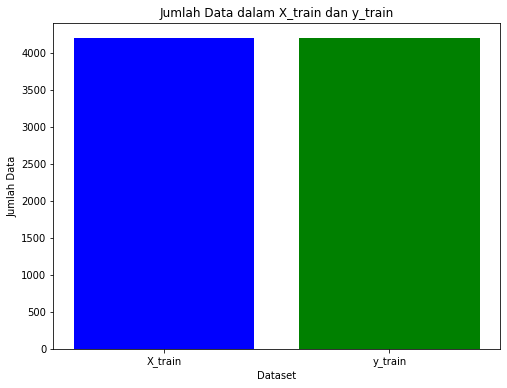

In [18]:
import matplotlib.pyplot as plt

# Menyiapkan data
labels = ['X_train', 'y_train']
jumlah_data = [X_train.shape[0], y_train.shape[0]]

# Membuat diagram batang
plt.figure(figsize=(8, 6))
plt.bar(labels, jumlah_data, color=['blue', 'green'])
plt.title('Jumlah Data dalam X_train dan y_train')
plt.xlabel('Dataset')
plt.ylabel('Jumlah Data')
plt.show()

In [19]:
# scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train) # compute the mean and standard deviation to be used for later scaling
X_train_scaled = scaler.transform(X_train)

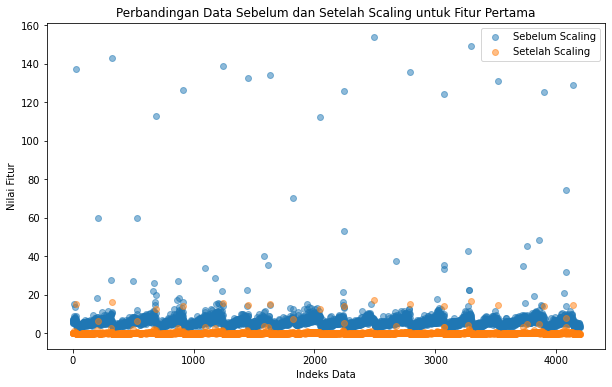

In [20]:
import matplotlib.pyplot as plt

# Memilih fitur pertama dari X_train
fitur_pertama_sebelum_scaling = X_train.iloc[:, 0]
fitur_pertama_setelah_scaling = X_train_scaled[:, 0]

# Membuat scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(fitur_pertama_sebelum_scaling)), fitur_pertama_sebelum_scaling, label='Sebelum Scaling', alpha=0.5)
plt.scatter(range(len(fitur_pertama_setelah_scaling)), fitur_pertama_setelah_scaling, label='Setelah Scaling', alpha=0.5)
plt.title('Perbandingan Data Sebelum dan Setelah Scaling untuk Fitur Pertama')
plt.xlabel('Indeks Data')
plt.ylabel('Nilai Fitur')
plt.legend()
plt.show()

# Training Time:

In [21]:
#random forest

rand_forest = RandomForestRegressor(n_estimators=100, criterion='mae', oob_score=True, n_jobs=-1)
start_time = time.time()
rand_forest.fit(X_train_scaled, y_train.values.flatten())
print("Training Time:", time.time()-start_time)
print('Training Score:', rand_forest.score(X_train_scaled, y_train.values.flatten()))
rand_forest.oob_score_

/home/saiful/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(


Training Time: 100.64368629455566
Training Score: 0.9017105233442247


0.3201953129228893

In [22]:
rand_forest.feature_importances_

array([0.43645032, 0.15311079, 0.11229925, 0.11001081, 0.18812883])

In [28]:
from sklearn.metrics import mean_absolute_error

# Prediksi nilai target menggunakan model Random Forest
predicted_values = rand_forest.predict(X_train_scaled)

# Menghitung MAE antara nilai sebenarnya dan nilai prediksi
mae_ranfor = mean_absolute_error(y_train, predicted_values)
print('Mean Absolute Error (MAE):', mae_ranfor)

Mean Absolute Error (MAE): 0.8891885755942445


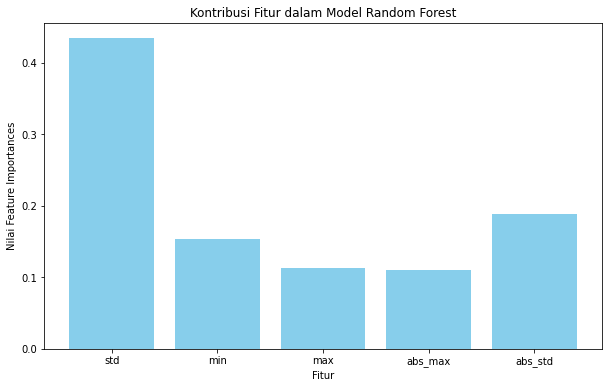

In [23]:
import matplotlib.pyplot as plt

# Fitur-fitur yang digunakan dalam model
fitur = ['std', 'min', 'max', 'abs_max', 'abs_std']

# Nilai feature importances dari model Random Forest
nilai_importansi_fitur = [0.43397242, 0.15384941, 0.11315353, 0.11061095, 0.18841369]

# Membuat plot
plt.figure(figsize=(10, 6))
plt.bar(fitur, nilai_importansi_fitur, color='skyblue')
plt.xlabel('Fitur')
plt.ylabel('Nilai Feature Importances')
plt.title('Kontribusi Fitur dalam Model Random Forest')
plt.show()

In [24]:
#svm

svr = SVR(kernel = 'rbf', tol = 0.01, C= 2, gamma=0.02)
start_time = time.time()
svr.fit(X_train_scaled, y_train.values.flatten())
print("Training Time:", time.time()-start_time)
print('Training Score:', svr.score(X_train_scaled, y_train.values.flatten()))

Training Time: 1.3726060390472412
Training Score: 0.3044303767636417


In [29]:
from sklearn.metrics import mean_absolute_error

# Prediksi nilai target menggunakan model SVR
predicted_values = svr.predict(X_train_scaled)

# Menghitung MAE antara nilai sebenarnya dan nilai prediksi
mae_svm = mean_absolute_error(y_train, predicted_values)
print('Mean Absolute Error (MAE):', mae_svm)

Mean Absolute Error (MAE): 2.4009822079754186


In [26]:
#catboost

pool = Pool(X_train, y_train)
cat_boost = CatBoostRegressor(loss_function='MAE', boosting_type='Ordered') # iterations=no. of trees
start_time = time.time()
cat_boost.fit(pool, silent=True) # don't show training | verbose
print("Time taken to train:", time.time()-start_time)
cat_boost.best_score_

Time taken to train: 6.466377019882202


{'learn': {'MAE': 2.0530607467640656}}

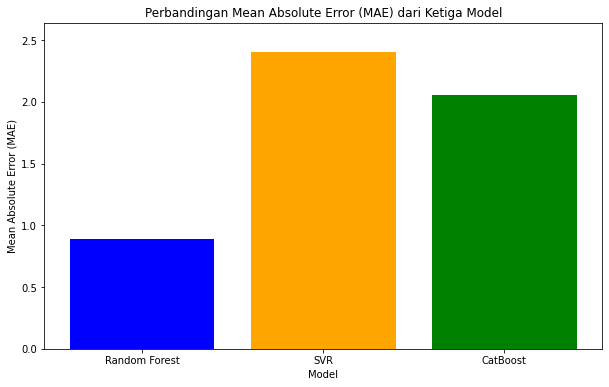

In [32]:
import matplotlib.pyplot as plt

# Daftar model dan nilai MAE
models = ['Random Forest', 'SVR', 'CatBoost']
mae_values = [mae_ranfor, mae_svm, cat_boost.best_score_['learn']['MAE']]

# Membuat diagram batang untuk membandingkan MAE
plt.figure(figsize=(10, 6))
plt.bar(models, mae_values, color=['blue', 'orange', 'green'])
plt.title('Perbandingan Mean Absolute Error (MAE) dari Ketiga Model')
plt.xlabel('Model')
plt.ylabel('Mean Absolute Error (MAE)')
plt.ylim(0, max(mae_values) * 1.1)  # Skala sumbu y agar cukup untuk menampilkan semua nilai MAE
plt.show()

In [35]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor, Pool
import time


def gen_features(series):
    features = {
        'std': series.std(),
        'min': series.min(),
        'max': series.max(),
        'abs_max': np.abs(series).max(),
        'abs_std': np.abs(series).std()
    }
    return pd.Series(features)

# Load the data
train = pd.read_csv('train.csv', iterator=True, chunksize=150000,
                    dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X = pd.DataFrame()
y = pd.Series(dtype=np.float64)

# Process each chunk
for df in train:
    ch = gen_features(df['acoustic_data'])
    X = X.append(ch, ignore_index=True)
    y = y.append(pd.Series(df['time_to_failure'].values[-1]))


# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize models
rand_forest = RandomForestRegressor(n_estimators=100, criterion='mae', oob_score=True, n_jobs=-1)
svr = SVR(kernel='rbf', tol=0.01, C=2, gamma=0.02)
cat_boost = CatBoostRegressor(loss_function='MAE', boosting_type='Ordered', silent=True)

# Function to perform cross-validation
def cross_validate(model, X, y, kf):
    mae_scores = []
    train_times = []

    for train_index, test_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        
        # Scale the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # Train the model
        start_time = time.time()
        model.fit(X_train_scaled, y_train)
        train_time = time.time() - start_time
        
        # Make predictions
        y_pred = model.predict(X_val_scaled)
        
        # Calculate MAE
        mae = mean_absolute_error(y_val, y_pred)
        mae_scores.append(mae)
        train_times.append(train_time)
    
    return mae_scores, train_times

# Perform cross-validation for Random Forest
rf_mae_scores, rf_train_times = cross_validate(rand_forest, X, y, kf)
print(f'Random Forest - Mean MAE: {np.mean(rf_mae_scores)}, Std MAE: {np.std(rf_mae_scores)}, Mean Train Time: {np.mean(rf_train_times)}')

# Perform cross-validation for SVM
svm_mae_scores, svm_train_times = cross_validate(svr, X, y, kf)
print(f'SVM - Mean MAE: {np.mean(svm_mae_scores)}, Std MAE: {np.std(svm_mae_scores)}, Mean Train Time: {np.mean(svm_train_times)}')

# Perform cross-validation for CatBoost
catboost_mae_scores, catboost_train_times = cross_validate(cat_boost, X, y, kf)
print(f'CatBoost - Mean MAE: {np.mean(catboost_mae_scores)}, Std MAE: {np.std(catboost_mae_scores)}, Mean Train Time: {np.mean(catboost_train_times)}')

/tmp/ipykernel_9459/1679313961.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X = X.append(ch, ignore_index=True)
/tmp/ipykernel_9459/1679313961.py:31: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = y.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/1679313961.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X = X.append(ch, ignore_index=True)
/tmp/ipykernel_9459/1679313961.py:31: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = y.append(pd.Series(df['time_to_failure'].values[-1]))
/tmp/ipykernel_9459/1679313961.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pa

Random Forest - Mean MAE: 2.3609698727404775, Std MAE: 0.05305582783120884, Mean Train Time: 80.1677472114563
SVM - Mean MAE: 2.4242110073870724, Std MAE: 0.05442879759358004, Mean Train Time: 0.7993916988372802
CatBoost - Mean MAE: 2.2525419532041875, Std MAE: 0.039687787104176385, Mean Train Time: 4.752826786041259


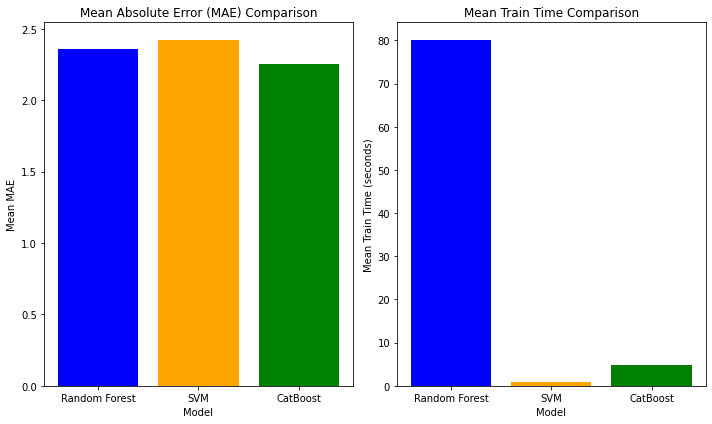

In [36]:
import matplotlib.pyplot as plt

# List model
models = ['Random Forest', 'SVM', 'CatBoost']

# Mean MAE values
mae_means = [np.mean(rf_mae_scores), np.mean(svm_mae_scores), np.mean(catboost_mae_scores)]

# Mean train times
train_times = [np.mean(rf_train_times), np.mean(svm_train_times), np.mean(catboost_train_times)]

# Plotting
plt.figure(figsize=(10, 6))

# Bar plot for Mean MAE
plt.subplot(1, 2, 1)
plt.bar(models, mae_means, color=['blue', 'orange', 'green'])
plt.title('Mean Absolute Error (MAE) Comparison')
plt.xlabel('Model')
plt.ylabel('Mean MAE')

# Bar plot for Mean Train Time
plt.subplot(1, 2, 2)
plt.bar(models, train_times, color=['blue', 'orange', 'green'])
plt.title('Mean Train Time Comparison')
plt.xlabel('Model')
plt.ylabel('Mean Train Time (seconds)')

plt.tight_layout()
plt.show()

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor

# Inisialisasi model SVM, Random Forest, dan CatBoost
svm_model = SVR(kernel='rbf', tol=0.01, C=2, gamma=0.02)
rf_model = RandomForestRegressor(n_estimators=100, criterion='mae', n_jobs=-1)
catboost_model = CatBoostRegressor(loss_function='MAE', boosting_type='Ordered', silent=True)

# Cross-validation untuk model SVM
svm_scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
svm_mae = -svm_scores.mean()

# Cross-validation untuk model Random Forest
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
rf_mae = -rf_scores.mean()

# Cross-validation untuk model CatBoost
catboost_scores = cross_val_score(catboost_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
catboost_mae = -catboost_scores.mean()

# Menampilkan hasil perbandingan
print("Mean Absolute Error (MAE) - SVM:", svm_mae)
print("Mean Absolute Error (MAE) - Random Forest:", rf_mae)
print("Mean Absolute Error (MAE) - CatBoost:", catboost_mae)

/home/saiful/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
/home/saiful/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
/home/saiful/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
/home/saiful/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
/home/saiful/anaconda3/lib/python3.9/site-packages/sklea

Mean Absolute Error (MAE) - SVM: 2.4448140953612145
Mean Absolute Error (MAE) - Random Forest: 2.3524787275793
Mean Absolute Error (MAE) - CatBoost: 2.257638702843746


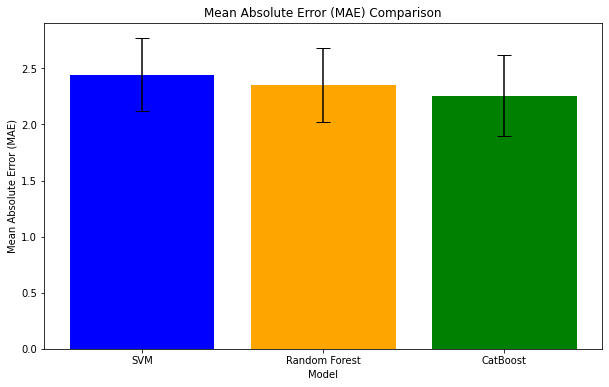

In [38]:
import matplotlib.pyplot as plt

# List model
models = ['SVM', 'Random Forest', 'CatBoost']

# Mean MAE values
mae_means = [svm_mae, rf_mae, catboost_mae]

# Standard deviation of MAE values
mae_std = [np.std(svm_scores), np.std(rf_scores), np.std(catboost_scores)]

# Plotting
plt.figure(figsize=(10, 6))

# Bar plot for Mean MAE
plt.bar(models, mae_means, yerr=mae_std, capsize=7, color=['blue', 'orange', 'green'])
plt.title('Mean Absolute Error (MAE) Comparison')
plt.xlabel('Model')
plt.ylabel('Mean Absolute Error (MAE)')

plt.show()

>Pendekatan pertama memungkinkan lebih banyak fleksibilitas dalam mengontrol proses cross-validation dan menerapkan langkah-langkah tambahan seperti scaling data.

>Pendekatan kedua lebih sederhana dan lebih mudah digunakan karena tidak memerlukan penulisan fungsi tambahan atau langkah-langkah manual untuk cross-validation.

## Using LSTM:

In [39]:
train_tfread = pd.read_csv('train.csv', iterator = True, chunksize = 150000, nrows = 6000000,
                       dtype = {'acoustic_data': np.int16, 'time_to_failure': np.float32})
X_train_seq = []
y_train_seq = []
for df in train_tfread:
  X_train_seq.append(df['acoustic_data'].to_numpy().reshape(-1,1))
  y_train_seq.append(df['time_to_failure'].values[-1])

In [40]:
X_train_seq = np.array(X_train_seq)
y_train_seq = np.array(y_train_seq)
X_train_seq.shape[1:]

(150000, 1)

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization

2024-06-09 15:44:42.984895: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-09 15:44:42.985131: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [43]:
rnn = Sequential()

rnn.add(LSTM(2, input_shape=X_train_seq.shape[1:], return_sequences=True))
rnn.add(Dropout(rate=0.2))
rnn.add(BatchNormalization())

#rnn.add(LSTM(150, input_shape=X_train_seq.shape[1:], return_sequences=True))
#rnn.add(Dropout(rate=0.2))
#rnn.add(BatchNormalization())

rnn.add(LSTM(2, input_shape=X_train_seq.shape[1:]))
rnn.add(Dropout(rate=0.2))
rnn.add(BatchNormalization())

rnn.add(Dense(1, activation='elu'))
rnn.add(Dropout(rate=0.2))

rnn.add(Dense(1))


2024-06-09 15:44:54.577951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 15:44:54.578484: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-09 15:44:54.578698: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-06-09 15:44:54.578875: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-06-09 15:44:54.579139: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [44]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
rnn.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mae'])

/home/saiful/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [45]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150000, 2)         32        
                                                                 
 dropout (Dropout)           (None, 150000, 2)         0         
                                                                 
 batch_normalization (BatchN  (None, 150000, 2)        8         
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 2)                 40        
                                                                 
 dropout_1 (Dropout)         (None, 2)                 0         
                                                                 
 batch_normalization_1 (Batc  (None, 2)                8         
 hNormalization)                                        

In [33]:
time1 = time.time()
rnn.fit(X_train_seq, y_train_seq, epochs=2, batch_size=4)
print("Training Time:", time.time()-time1)

Epoch 1/2
40/40 [==============================] - 1151s 29s/sample - loss: 2.2647 - mean_absolute_error: 2.2647
Epoch 2/2
40/40 [==============================] - 1154s 29s/sample - loss: 2.3906 - mean_absolute_error: 2.3906
Training Time: 2309.2217054367065


In [ ]:
X_test_seq = []

for file in os.listdir('test'):
  data = pd.read_csv(os.path.join('test', file), dtype = {'acoustic_data': np.int16})
  X_test_seq.append(data['acoustic_data'].to_numpy().reshape(-1,1))

In [ ]:
# This takes more than 45 min
#X_pred_rnn = rnn.predict(np.array(X_test_seq))

In [129]:
pd.Series(X_pred_rnn[0]).describe()

count    1.000000
mean     0.199942
std           NaN
min      0.199942
25%      0.199942
50%      0.199942
75%      0.199942
max      0.199942
dtype: float64

**RNN tidak bekerja dengan baik**

## Best Model:

Di antara semua model, model `RandomForest` dan `SVR` adalah yang terbaik.<br>
Mari kita evaluasi berdasarkan data pengujian.<br>
Melatih jaringan LSTM menggunakan urutan 150000 juga tidak berhasil. Pelatihannya sangat memakan waktu dan MAE-nya pun besar.<br>
Meskipun Randomforest dan SVR dilatih menggunakan nilai parameter terbaik, kami akan menyempurnakannya lebih lanjut.

# Evaluate Models:

## Process test data:

In [ ]:
X_test = pd.DataFrame()
seg_ids = pd.Series()

for file in os.listdir('test'):
  data = pd.read_csv(os.path.join('test', file), dtype = {'acoustic_data': np.int16})
  data_fet = gen_features(data['acoustic_data'])
  X_test = X_test.append(data_fet, ignore_index=True)
  seg_ids = seg_ids.append(pd.Series(os.path.splitext(file)[0]))

In [51]:
# Fungsi untuk membangkitkan fitur dari data akustik
def gen_features(series):
    features = {
        'std': series.std(),
        'min': series.min(),
        'max': series.max(),
        'abs_max': np.abs(series).max(),
        'abs_std': np.abs(series).std()
    }
    return pd.Series(features)

chunksize = 150000
test_features = []

# Iterasi melalui setiap file dalam folder 'test'
for file in os.listdir('test'):
    # Pastikan hanya membaca file CSV
    if file.endswith('.csv'):
        # Baca data dari file
        data = pd.read_csv(os.path.join('test', file), dtype={'acoustic_data': np.int16})
        # Iterasi melalui setiap chunk data
        for chunk in pd.read_csv(os.path.join('test', file), chunksize=chunksize, dtype={'acoustic_data': np.int16}):
            # Ekstrak fitur dari setiap chunk
            chunk_features = gen_features(chunk['acoustic_data'])
            # Tambahkan fitur ke dalam list test_features
            test_features.append(chunk_features)

# Gabungkan semua fitur menjadi DataFrame
test_features_df = pd.concat(test_features, axis=0).reset_index(drop=True)

# Tampilkan DataFrame dengan fitur-fiturnya
print(test_features_df)

0          6.614276
1       -167.000000
2        170.000000
3        170.000000
4          5.755909
            ...    
13115      5.604410
13116    -73.000000
13117     80.000000
13118     80.000000
13119      4.620834
Length: 13120, dtype: float64


In [48]:
import os
import pandas as pd

# Tentukan path ke folder test
test_folder_path = '/home/saiful/earthquake-prediction/Earthquake-Prediction02/test'

# Dapatkan daftar semua file dengan ekstensi .csv dalam folder test
test_files = [file for file in os.listdir(test_folder_path) if file.endswith('.csv')]

# Hitung jumlah total data dalam semua file CSV
total_rows = 0
for file in test_files:
    file_path = os.path.join(test_folder_path, file)
    df = pd.read_csv(file_path)
    total_rows += len(df)

print(f"Jumlah total data dalam semua file CSV di folder test: {total_rows}")

Jumlah total data dalam semua file CSV di folder test: 393600000


In [53]:
test_features = []

# Iterasi melalui setiap file dalam folder 'test'
for file in os.listdir('test'):
    # Pastikan hanya membaca file CSV
    if file.endswith('.csv'):
        # Baca data dari file
        data = pd.read_csv(os.path.join('test', file), dtype={'acoustic_data': np.int16})
        # Iterasi melalui setiap chunk data
        for chunk in pd.read_csv(os.path.join('test', file), chunksize=chunksize, dtype={'acoustic_data': np.int16}):
            # Ekstrak fitur dari setiap chunk
            chunk_features = gen_features(chunk['acoustic_data'])
            # Tambahkan fitur ke dalam list test_features
            test_features.append(chunk_features)

# Gabungkan semua fitur menjadi DataFrame
test_features_df = pd.concat(test_features, axis=0).reset_index(drop=True)

# Tampilkan DataFrame dengan fitur-fiturnya
print(test_features_df)

0          6.614276
1       -167.000000
2        170.000000
3        170.000000
4          5.755909
            ...    
13115      5.604410
13116    -73.000000
13117     80.000000
13118     80.000000
13119      4.620834
Length: 13120, dtype: float64


In [54]:
test_features_df = pd.concat(test_features, axis=0)

In [55]:
test_features_df.to_csv('features.csv', index=False)

In [56]:
features = pd.read_csv('features.csv')

In [57]:
X_test = pd.DataFrame()
seg_ids = []
for file in os.listdir('test'):
    if file.endswith('.csv'):
        seg_id = os.path.splitext(file)[0]
        seg_ids.append(seg_id)


X_test = pd.concat([features, pd.Series(seg_ids, name='seg_id')], axis=1)

In [58]:
features.tail()

0
13115   5.604410
13116 -73.000000
13117  80.000000
13118  80.000000
13119   4.620834

In [59]:
print(f"Jumlah baris pada features: {features.shape[0]}")

Jumlah baris pada features: 13120


In [61]:
X_test = pd.DataFrame()  # Inisialisasi DataFrame untuk fitur-fitur data test
seg_ids = []  # List untuk menyimpan ID segmen

# Iterasi melalui setiap file dalam folder 'test'
for file in os.listdir('test'):
    if file.endswith('.csv'):
        seg_id = os.path.splitext(file)[0]
        seg_ids.append(seg_id)
        
        # Membaca file dari folder 'test'
        data = pd.read_csv(os.path.join('test', file), dtype={'acoustic_data': np.int16})
        # Memperoleh fitur dari data akustik
        data_fet = gen_features(data['acoustic_data'])
        # Menambahkan fitur ke dalam DataFrame X_test
        X_test = X_test.append(data_fet, ignore_index=True)

# Menampilkan DataFrame dengan fitur-fiturnya
print(X_test)

/tmp/ipykernel_9459/3829829733.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test = X_test.append(data_fet, ignore_index=True)
/tmp/ipykernel_9459/3829829733.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test = X_test.append(data_fet, ignore_index=True)
/tmp/ipykernel_9459/3829829733.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test = X_test.append(data_fet, ignore_index=True)
/tmp/ipykernel_9459/3829829733.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test = X_test.append(data_fet, ignore_index=True)
/tmp/ipykernel_9459/3829829733.py:15: FutureWarning: The frame.append method is deprecated and will 

            std    min    max  abs_max    abs_std
0      6.614276 -167.0  170.0    170.0   5.755909
1      6.131407 -102.0   98.0    102.0   5.151282
2      4.519233  -68.0   66.0     68.0   3.777649
3      4.299883 -138.0  131.0    138.0   3.803923
4      4.363033 -166.0  162.0    166.0   3.910509
...         ...    ...    ...      ...        ...
2619   6.123615 -104.0  132.0    132.0   5.094102
2620   5.605294  -91.0  106.0    106.0   4.711123
2621   6.003525 -191.0  219.0    219.0   5.290573
2622  11.844751 -529.0  376.0    529.0  10.717427
2623   5.604410  -73.0   80.0     80.0   4.620834

[2624 rows x 5 columns]


/tmp/ipykernel_9459/3829829733.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test = X_test.append(data_fet, ignore_index=True)
/tmp/ipykernel_9459/3829829733.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test = X_test.append(data_fet, ignore_index=True)
/tmp/ipykernel_9459/3829829733.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test = X_test.append(data_fet, ignore_index=True)
/tmp/ipykernel_9459/3829829733.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test = X_test.append(data_fet, ignore_index=True)


In [62]:
X_test_scaled = scaler.transform(X_test)

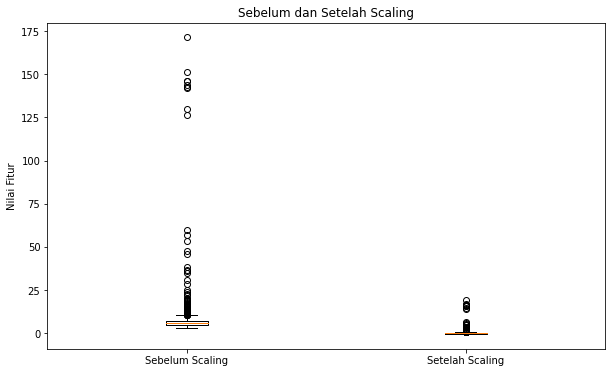

In [67]:
import matplotlib.pyplot as plt

# Memilih fitur pertama dari X_test
fitur_pertama_sebelum_scaling = X_test.iloc[:, 0]
fitur_pertama_setelah_scaling = X_test_scaled[:, 0]

# Membuat boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([fitur_pertama_sebelum_scaling, fitur_pertama_setelah_scaling], labels=['Sebelum Scaling', 'Setelah Scaling'])
plt.title('Sebelum dan Setelah Scaling')
plt.ylabel('Nilai Fitur')
plt.show()

In [68]:
X_test.describe()

std          min          max      abs_max      abs_std
count  2624.000000  2624.000000  2624.000000  2624.000000  2624.000000
mean      6.684161  -154.099848   165.683689   173.052591     5.840791
std       8.744635   291.376009   276.517022   308.452089     8.576916
min       2.848341 -6323.000000    28.000000    28.000000     2.487417
25%       4.640139  -162.000000    93.000000    95.000000     3.943621
50%       5.816308  -117.000000   128.000000   133.000000     4.919655
75%       7.055588   -81.000000   172.000000   179.250000     6.044220
max     171.321744   -20.000000  6741.000000  6741.000000   168.390405

In [69]:
# Mengetahui jumlah baris dan kolom pada DataFrame X_test
num_rows, num_columns = X_test.shape
print(f"Jumlah data (baris): {num_rows}")
print(f"Jumlah fitur (kolom): {num_columns}")

Jumlah data (baris): 2624
Jumlah fitur (kolom): 5


## Make Predictions:

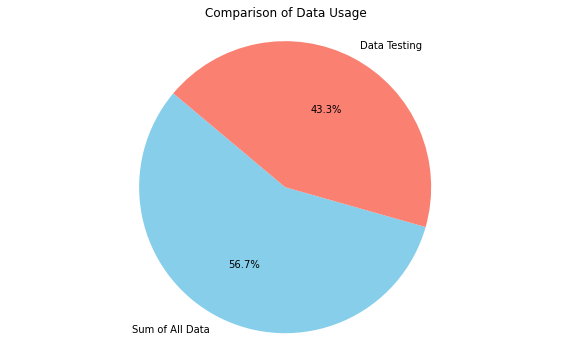

In [70]:
import matplotlib.pyplot as plt

# Data
labels = ['Sum of All Data', 'Data Testing']
sizes = [393, 300]

# Colors
colors = ['skyblue', 'salmon']

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Comparison of Data Usage')
plt.show()

In [71]:
forest_pred = rand_forest.predict(X_test_scaled)
svr_pred = svr.predict(X_test_scaled)

In [72]:
svr_pred

array([4.52984148, 4.86201986, 6.53115399, ..., 5.35288359, 1.86964735,
       5.40898842])

In [73]:
forest_pred

array([5.02651415, 3.62754939, 7.81027777, ..., 6.06126373, 2.35937594,
       3.14491578])

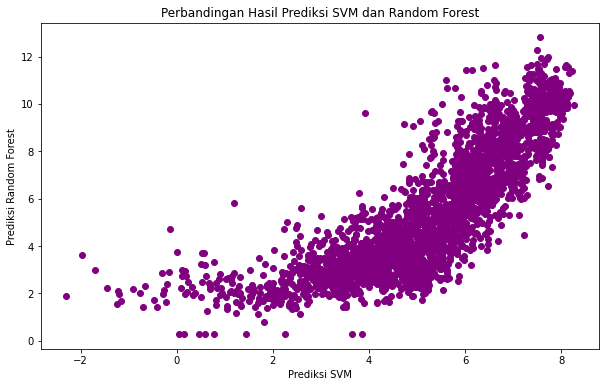

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Scatter plot untuk hasil prediksi SVM vs Random Forest
plt.scatter(svr_pred, forest_pred, color='purple')

plt.title('Perbandingan Hasil Prediksi SVM dan Random Forest')
plt.xlabel('Prediksi SVM')
plt.ylabel('Prediksi Random Forest')
plt.show()

***Dari visualisasi perbandingan hasil prediksi antara model Support Vector Machine (SVM) dan Random Forest, terlihat bahwa prediksi dari Random Forest lebih baik daripada SVM.***

Berdasarkan pola sebaran titik-titik pada plot. Untuk model SVM, titik-titik prediksi tersebar cukup luas dan menyimpang jauh dari garis diagonal (garis yang menunjukkan prediksi sempurna). Sedangkan untuk Random Forest, sebagian besar titik-titik prediksi terkumpul di dekat garis diagonal, menunjukkan bahwa prediksinya lebih akurat dan mendekati nilai sebenarnya.

### Result:

In [30]:
sub = pd.DataFrame(columns=['seg_id', 'time_to_failure'])
sub['seg_id'] = seg_ids
sub['time_to_failure'] = forest_pred
sub.head()

seg_id  time_to_failure
0  seg_5924f5         4.609908
0  seg_5975f4         3.309058
0  seg_455b16         3.310566
0  seg_7e3b3e         3.698824
0  seg_e5fbc1         2.421940